# Compare self-trained models

## Compare models on training dataset

In [1]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1" # suppresses Huggingface warning of storing data rather than symlinking it
from transformers import AutoTokenizer, AutoModelForPreTraining, pipeline

import sys
sys.path.append('../../')
# load functions for import of clinicaltrials.gov data written previously
from app.data.loader import load_trials_json, extract_from_clinicaltrials
from app.nlp.pipelines import load_ner_trained_pipeline
from app.nlp.utils import * # custom functions required for NER and summarization
from app.nlp.evaluate_model import elements_from_cell, substring_partial_overlap, evaluate_ner_model_partial_overlap, measure_processing_time, calculate_batch_throughput
from rouge_score import rouge_scorer # library for ROUGE score calculation

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# data extracted during training on colab, listed are metrics on test dataset
train_results_cb = {'model':'compact-biobert','training_time':1778.84,'inference_time': 23.86, 'eval_loss': 0.005029556341469288, 'eval_precision': 0.9908081194944466, 'eval_recall': 0.9919478527607362, 'eval_f1': 0.9913776585552788, 'eval_runtime': 23.8608, 'eval_samples_per_second': 64.835, 'eval_steps_per_second': 8.131, 'epoch': 3.0}
train_results_mb = {'model':'bio-mobilebert','training_time':1638.39,'inference_time': 23.34, 'eval_loss': 0.004630366340279579, 'eval_precision': 0.9858454475899006, 'eval_recall': 0.9881134969325154, 'eval_f1': 0.9869781692837993, 'eval_runtime': 23.3364, 'eval_samples_per_second': 66.291, 'eval_steps_per_second': 8.313, 'epoch': 3.0}
train_results_bb = {'model':'biobert-v1.1','training_time':3492.89,'inference_time': 44.67, 'eval_loss': 0.002541647059842944, 'eval_precision': 0.9961715160796325, 'eval_recall': 0.9976993865030674, 'eval_f1': 0.9969348659003832, 'eval_runtime': 44.6654, 'eval_samples_per_second': 34.635, 'eval_steps_per_second': 4.343, 'epoch': 3.0}


# Create a DataFrame
df_traing = pd.DataFrame([train_results_cb, train_results_mb, train_results_bb])

# Display the DataFrame
print(df_traing)


             model  training_time  inference_time  eval_loss  eval_precision  \
0  compact-biobert        1778.84           23.86   0.005030        0.990808   
1   bio-mobilebert        1638.39           23.34   0.004630        0.985845   
2     biobert-v1.1        3492.89           44.67   0.002542        0.996172   

   eval_recall   eval_f1  eval_runtime  eval_samples_per_second  \
0     0.991948  0.991378       23.8608                   64.835   
1     0.988113  0.986978       23.3364                   66.291   
2     0.997699  0.996935       44.6654                   34.635   

   eval_steps_per_second  epoch  
0                  8.131    3.0  
1                  8.313    3.0  
2                  4.343    3.0  


## Compare models on GOLD dataset

In [2]:
PROJECT_ROOT = os.path.expanduser('~/Documents/github/biomed_extractor')

ner_pipeline_hf = pipeline(
    "token-classification",
    model="kamalkraj/BioELECTRA-PICO",
    aggregation_strategy="simple"
)

model_dirs = [
    os.path.join(PROJECT_ROOT, 'app/model/nlpie_compact_biobert_PICO'),
    os.path.join(PROJECT_ROOT, 'app/model/nlpie_bio-mobilebert_PICO'),
    os.path.join(PROJECT_ROOT, 'app/model/dmis-lab_biobert-v1.1')
]

ner_pipelines = [
    load_ner_trained_pipeline(model_dir=dir_path)
    for dir_path in model_dirs
]


Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


In [ ]:
# load gold standard trials
# Load and process data from clinicaltrials.gov
PROJECT_ROOT = os.path.expanduser('~/Documents/github/biomed_extractor')

# Data directory at top level
DATA_DIR = os.path.join(PROJECT_ROOT, 'data\\annotated')

df_json = load_trials_json(filepath = DATA_DIR, filename ='study_details_supergoldseet.json')
#print(df_json.head())
mydf_manual_annotation = extract_from_clinicaltrials(df_json)
mydf_manual_annotation.head()

Loaded 20 records from ctg-studies_for_gold.json


,nctId,briefSummary,detailedDescription,inclusion_criteria,exclusion_criteria,intervention_name_clean,outcomes_name
0,NCT00667810,This is a study to evaluate the efficacy and s...,,"diagnosis of probable alzheimer disease (ad), ...",significant neurological disease other than ad...,bapineuzumab; placebo,The Change From Baseline in the Alzheimer's Di...
1,NCT00676143,This is a study to evaluate the efficacy and s...,,"diagnosis of probable ad, with mmse score of 1...",significant neurological disease other than ad...,bapineuzumab; placebo,Change From Baseline in Alzheimer's Disease As...
2,NCT01561430,The purpose of this Phase 1/Phase 2 study is t...,,meets criteria for mci due to ad or mild adall...,participant in another drug or device study; h...,LY2886721; Placebo,Change From Baseline to 12 Weeks in Cerebrospi...
3,NCT01900665,To test the idea that solanezumab will slow th...,,meets national institute of neurological and c...,does not have a reliable caregiver who is in f...,Solanezumab; Placebo,Change From Baseline in Alzheimer's Disease As...
4,NCT02565511,The purpose of this study was to test whether ...,The study (also known as the Generation Study ...,consented to receive disclosure of their risk ...,any disability that prevented the participant ...,CAD106 Immunotherapy; Placebo to CAD106; CNP52...,Time to Event (Diagnosis of Mild Cognitive Imp...


In [4]:
# Process all NER pipelines on the gold dataset and store results in a list
ner_results = []

# Process custom models
for ner_pipeline in ner_pipelines:
    ner_res_model = process_trials_for_retrained_PICO(mydf_manual_annotation, ner_pipeline)
    ner_res_model.sort_values(by=['nctId'], inplace=True)
    ner_res_model.rename(columns={
        'population_extracted': 'population',
        'intervention_extracted': 'intervention',
        'comparator_extracted': 'comparator',
        'outcome_extracted': 'outcome',
        'summary_extracted': 'summary'
    }, inplace=True)
    # Only append, do not merge or concat
    ner_results.append(ner_res_model[['nctId', 'population', 'intervention', 'comparator', 'outcome', 'summary']].copy())

# Huggingface pipeline
ner_res_model_hf = process_trials_for_PICO(mydf_manual_annotation, ner_pipeline_hf)
ner_res_model_hf.sort_values(by=['nctId'], inplace=True)
ner_res_model_hf.rename(columns={
    'population_extracted': 'population',
    'intervention_extracted': 'intervention',
    'comparator_extracted': 'comparator',
    'outcome_extracted': 'outcome',
    'summary_extracted': 'summary'
}, inplace=True)
ner_results = [ner_res_model_hf[['nctId', 'population', 'intervention', 'comparator', 'outcome', 'summary']].copy()] + ner_results

model_names = ["BioELECTRA-PICO", "nlpie_compact_biobert_PICO", "nlpie_bio-mobilebert_PICO", "dmis-lab_biobert-v1.1"]
ner_results_dict = dict(zip(model_names, ner_results))

# Peek into results
for name, df in ner_results_dict.items():
    print(f"{name} predictions:")
    print(df.head())


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


BioELECTRA-PICO predictions:
         nctId                                         population  \
0  NCT00667810  diagnosis of probable alzheimer disease ( ad )...   
1  NCT00676143  diagnosis of probable ad, with mmse score of 1...   
2  NCT01561430  absence of dementia; clinical dementia rating ...   
3  NCT01900665  ) result consistent with the presence of amylo...   
4  NCT02565511  homozygous apoe4 genotype.; male or female, ag...   

     intervention comparator  \
0    bapineuzumab              
1    bapineuzumab              
2                              
3     solanezumab    placebo   
4  cad106; cnp520    placebo   

                                             outcome  \
0                                   efficacy; safety   
1                                   efficacy; safety   
2                                                      
3                                  cognitive decline   
4  and body weight loss; cognitive function, brai...   

                          

In [ ]:
# load GOLD-standard results
df_gold = load_trials_json(filepath = DATA_DIR, filename ='supergoldset_standard.json')
for col in ["population", "intervention","comparator", "outcome"]:
    df_gold[col] = df_gold[col].apply(
        lambda x: '; '.join(str(e) for e in x) if isinstance(x, list) else x
    )
    # set to lowercase (to align with automatic extraction)
    df_gold[col] = df_gold[col].str.lower()
df_gold.sort_values(by=['doc_id'], inplace=True)
df_gold["intervention"] = df_gold["intervention"].apply(normalize_intervention)
df_gold

Loaded 20 records from gold_standard.json


,doc_id,summary,population,intervention,comparator,outcome
12,NCT00667810,[This is a study to evaluate the efficacy and ...,patients with mild to moderate alzheimer disease,bapineuzumab,placebo,the change from baseline in the alzheimer's di...
11,NCT00676143,[This is a study to evaluate the efficacy and ...,patients with mild to moderate alzheimer disease,bapineuzumab,placebo,change from baseline in alzheimer's disease as...
13,NCT01561430,[The purpose of this Phase 1/Phase 2 study is ...,participants with mild cognitive impairment (m...,ly2886721,placebo,change from baseline to 12 weeks in cerebrospi...
19,NCT01900665,[To test the idea that solanezumab will slow t...,participants with mild ad,solanezumab,placebo,change from baseline in alzheimer's disease as...
3,NCT02565511,[The purpose of this study was to test whether...,cognitively unimpaired apoe4 homozygotes (hms)...,cad106 immunotherapy cnp520 alum,placebo,time to event (diagnosis of mild cognitive imp...
7,NCT02769000,[Evaluate safety and toxicity/adverse events a...,patients with early alzheimer's dementia,radiation 10 gy radiation 20 gy,,ctcae toxicity grading
14,NCT02783573,[The main purpose of this study is to evaluate...,participants with mild alzheimer's disease (ad...,lanabecestat,placebo,change from baseline in alzheimer´s disease as...
9,NCT02791191,[The main purpose of this study is to evaluate...,participants with mild alzheimer's disease (ad...,ly3202626,placebo,change from baseline in f-av-1451 positron emi...
15,NCT02884492,[This study is being done to learn about tau t...,elderly subjects with different clinical and b...,18f thk 5351,,18f-thk-5351 standardized uptake value ratio
10,NCT02972658,[This study is an extension of study I8D-MC-AZ...,participants with early alzheimer's disease de...,lanabecestat,,change from baseline analysis on the 13-item a...


In [6]:
pico_cols = ["population", "intervention", "comparator", "outcome"]
evaluation_tables = {}

for model_name, pred_df in ner_results_dict.items():
    # Measure processing time and throughput for each model
    if model_name == "BioELECTRA-PICO":
        # For Huggingface pipeline
        total_time, avg_time, median_time = measure_processing_time(process_trials_for_PICO, mydf_manual_annotation, ner_pipeline_hf)
    else:
        # For custom models
        # Find the corresponding pipeline by model_name if needed
        pipeline_idx = model_names.index(model_name)
        ner_pipeline = ner_pipelines[pipeline_idx - 1]  # -1 because HF is first
        total_time, avg_time, median_time = measure_processing_time(process_trials_for_retrained_PICO, mydf_manual_annotation, ner_pipeline)
    throughput = calculate_batch_throughput(total_time, len(mydf_manual_annotation))

    _, evaluation_table = evaluate_ner_model_partial_overlap(
        df_gold,
        pred_df,
        pico_cols,
        summary_gold_col='summary',
        summary_pred_col='summary',
        add_rouge=True,
        processing_time=(total_time, avg_time, median_time),
        batch_throughput=throughput
    )
    evaluation_tables[model_name] = evaluation_table

# print all evaluation tables
for name, table in evaluation_tables.items():
    print(f"Evaluation for {name}:")
    print(table)

Evaluation for BioELECTRA-PICO:
                                     precision    recall        f1      bleu  \
element                                                                        
population                            0.378636  0.722026  0.477297       NaN   
intervention                          0.794156  0.829167  0.759756       NaN   
comparator                            0.600000  0.566667  0.575000       NaN   
outcome                               0.362562  0.149262  0.155473       NaN   
SUMMARY_ROUGE-1                       0.798815  0.908080  0.833012       NaN   
SUMMARY_ROUGE-2                       0.768481  0.863371  0.798287       NaN   
SUMMARY_ROUGE-L                       0.779970  0.881646  0.812388       NaN   
SUMMARY_BLEU                               NaN       NaN       NaN  0.696942   
PROPORTION_ALL_PICO_PARTIAL_CORRECT        NaN       NaN       NaN       NaN   
PROCESSING_TIME                            NaN       NaN       NaN       NaN   
BATCH_TH

# **Comparison of BERT-based PICO NER Models**

### **1. Population**
- **Precision/Recall/F1:**  
  - All three models perform well, with F1 scores between 0.82–0.91.
  - **bio-mobilebert** has the highest F1 (0.91), suggesting slightly better capture of eligible populations from trial texts.
  - All three achieve high recall (0.86–0.96) and acceptable precision (0.82–0.91).
- **Interpretation:**  
  Models are robust at extracting population, with *bio-mobilebert* having an edge.

### **2. Intervention**
- **Precision/Recall/F1:**  
  - F1 hovers in the 0.57–0.62 range: good recall (~0.83–0.87), but lower precision (0.54–0.61).
  - **dmis-lab_biobert-v1.1** is strongest on precision (0.61) and has the highest F1 (0.62), though only marginally better than the others.
- **Interpretation:**  
  All models successfully recall interventions, but still display a tendency to overcall, resulting in modest precision. *dmis-lab_biobert* may be best balanced.

### **3. Comparator**  
- **Precision/Recall/F1:**  All identical (0.95). **Remember**: this isn't a test of the models, but of the comparator extraction function from cleaned intervention metadata.
- **Interpretation:** Do not use this column to differentiate models.

### **4. Outcome**
- **Precision/Recall/F1:**  
  - All models nearly identical and very strong (precision ~0.90, recall ~0.97, F1 ~0.93).
- **Interpretation:**  
  All are highly dependable for outcome extraction, with no practical difference detected in these results.

## **Strengths and Weaknesses**

| Model                  | Key Strength                                 | Weakness                                      |
|------------------------|----------------------------------------------|-----------------------------------------------|
| nlpie_compact_biobert  | Balanced on population/intervention/outcome  | Slightly lower on population F1               |
| nlpie_bio-mobilebert   | Strongest on population extraction           | Slightly lower on intervention precision/F1   |
| dmis-lab_biobert-v1.1  | Highest intervention F1 & strong population  | None significant in these results             |

## **Practical Guidance**

- **For most purposes:** Any of these models will deliver good outcome extraction, high-quality population extraction, and moderately reliable intervention extraction, though users should expect some false positives in interventions.
- **If population extraction is mission critical:** *nlpie_bio-mobilebert* edges out the others.
- **If a small advantage in intervention precision/F1 matters:** *dmis-lab_biobert-v1.1* is preferred.
- **Outcome extraction:** All are essentially tied.

## **Summary Table: Best by Metric**

| PICO Element    | Top Model                        | Notes                                   |
|-----------------|----------------------------------|-----------------------------------------|
| Population      | nlpie_bio-mobilebert             | F1 = 0.91, recall = 0.96                |
| Intervention    | dmis-lab_biobert-v1.1            | F1 = 0.62, precision = 0.61             |
| Outcome         | All (technical tie)              | F1 = 0.93                               |

## **Final Recommendation**

**All three BERT-based models are strong performers for PICO NER extraction.**  
- **nlpie_bio-mobilebert**: Ideal if maximizing population capture is most important.
- **dmis-lab_biobert-v1.1**: Slight edge in intervention extraction.
- In practice, the differences are minor; any are quite suitable for robust clinical trial PICO element extraction.

**(Comparator extraction scores cannot be used for model selection in this context.)**



In [7]:
tables_with_model = []
for name, table in evaluation_tables.items():
    print(f"Evaluation for {name}:")
    table["model"] = name
    tables_with_model.append(table)


# Combine all tables into one
combined_table = pd.concat(tables_with_model, ignore_index=False)

# Display or use the combined table
print(combined_table)


Evaluation for BioELECTRA-PICO:
Evaluation for nlpie_compact_biobert_PICO:
Evaluation for nlpie_bio-mobilebert_PICO:
Evaluation for dmis-lab_biobert-v1.1:
                                     precision    recall        f1      bleu  \
element                                                                        
population                            0.378636  0.722026  0.477297       NaN   
intervention                          0.794156  0.829167  0.759756       NaN   
comparator                            0.600000  0.566667  0.575000       NaN   
outcome                               0.362562  0.149262  0.155473       NaN   
SUMMARY_ROUGE-1                       0.798815  0.908080  0.833012       NaN   
SUMMARY_ROUGE-2                       0.768481  0.863371  0.798287       NaN   
SUMMARY_ROUGE-L                       0.779970  0.881646  0.812388       NaN   
SUMMARY_BLEU                               NaN       NaN       NaN  0.696942   
PROPORTION_ALL_PICO_PARTIAL_CORRECT        Na

Index(['precision', 'recall', 'f1', 'bleu', 'proportion', 'total_seconds',
       'avg_seconds_per_doc', 'median_seconds_per_doc', 'docs_per_minute'],
      dtype='object')


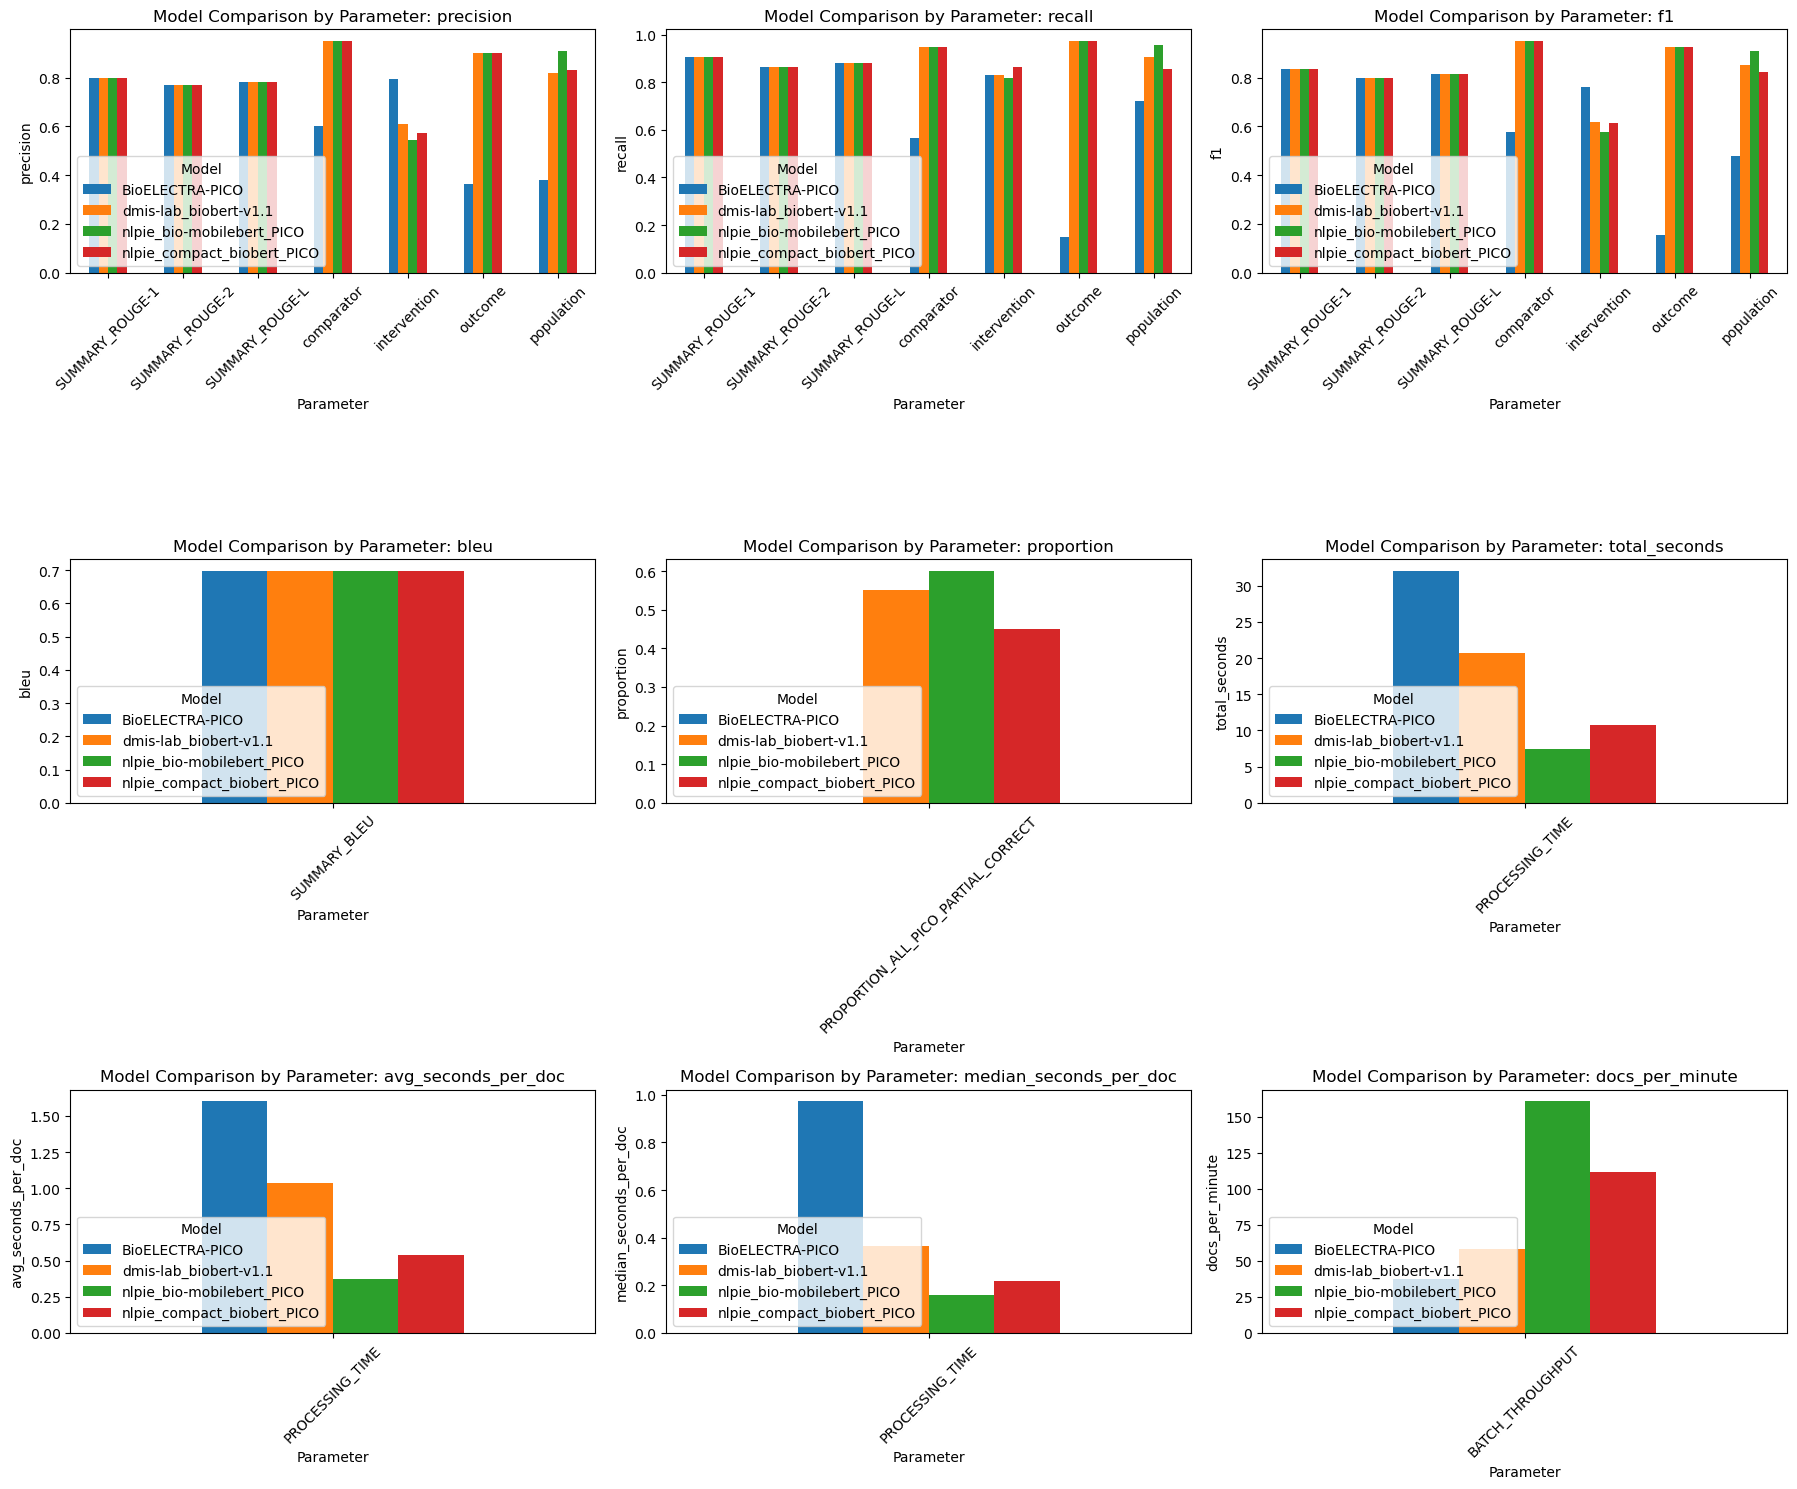

In [ ]:
# Rename 'element' to 'parameter' for clarity
df = combined_table.reset_index().rename(columns={'element': 'parameter'})


# List of metric columns to plot
metrics = combined_table.columns[0:9]


# Set up grid layout for subplots
n_cols = 3
n_rows = int(np.ceil(len(metrics) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()


# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    pivot_df = df.pivot(index='parameter', columns='model', values=metric)
    pivot_df = pivot_df.dropna(how='all')  # Remove rows where all model values are NaN
    if not pivot_df.empty:
        pivot_df.plot(kind='bar', ax=ax)
        ax.set_title(f'Model Comparison by Parameter: {metric}')
        ax.set_xlabel('Parameter')
        ax.set_ylabel(metric)
        ax.legend(title='Model', loc='lower left')
        ax.tick_params(axis='x', rotation=45)
        #ax.set_facecolor('white')
    else:
        ax.set_visible(False)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [14]:
combined_table.to_csv("all model results on gold.txt", sep='\t', decimal=',')